In [3]:
from __future__ import print_function, division

import pandas as pd
import geopandas as gpd
import numpy as np
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pylab as plt
import seaborn as sns
import csv
import dateutil
import os
import psycopg2
from bokeh.plotting import figure, show, output_file
import plotly

%matplotlib inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



In [4]:
## read json file for password 
import json
json_data = open("password.json").read() #reading password
passw = json.loads(json_data)

PASSWORD = str(passw["PASSWORD"])

In [5]:
# https://support.dominodatalab.com/hc/en-us/articles/207346026-Connecting-to-Redshift
# OAG Redshift Reference:
# https://docs.google.com/document/d/1FsTqbR9tk0Z7vxbDJ1vaNiEHfKEinxtOTU8YvBnUNI8/edit

HOST = "research1.cwcou8cgfav2.us-east-1.redshift.amazonaws.com"
PORT = 5439 # redshift default
USER = "cusp2017"

# Password either from environmental variable or input raw
# PASSWORD = os.environ['REDSHIFT_PASSWD']
#PASSWORD = raw_input()

In [6]:
# oag_civis
DATABASE = 'oag_civis'

def db_connection():
    conn = psycopg2.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database=DATABASE,
    )
    return conn


In [38]:
example_query = "Select * from agn_buildings.hpd_violations;"

conn = db_connection()
try:
    df_complaints = pd.read_sql(example_query, conn)
finally:
    conn.close()
df_complaints.head()

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,...,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate
0,2293181,444,130476,1,MANHATTAN,22,22,22,1 AVENUE,10010,...,None,None,09/10/1974,775,338584.0,D26-41.05 ADM CODE FILE WITH THIS DEPARTMENT R...,07/16/1974,19,VIOLATION CLOSED,03/10/2015
1,2293486,467,136913,1,MANHATTAN,2250,2250,2250,1 AVENUE,10010,...,None,None,None,772,338733.0,D26-41.03 ADM CODE FILE WITH THIS DEPARTMENT A...,05/10/1982,19,VIOLATION CLOSED,03/10/2015
2,10690403,41095,103427,1,MANHATTAN,622,620,622,WEST 137 STREET,36510,...,None,None,06/01/2015,508,5109809.0,Â§ 27-2005 ADM CODE REPAIR THE BROKEN OR DEFEC...,05/01/2015,19,VIOLATION CLOSED,08/12/2015
3,10645393,544,103340,1,MANHATTAN,26,26,28,1 AVENUE,10010,...,None,None,None,500,5084957.0,Â§ 26-1103 ADMIN. CODE: POST AND MAINTAIN A PR...,03/30/2015,2,NOV SENT OUT,03/30/2015
4,10468218,427,104211,1,MANHATTAN,213,211,213,1 AVENUE,10010,...,None,None,12/29/2014,556,4962386.0,Â§ 27-2013 ADM CODE PAINT WITH LIGHT COLORED P...,12/08/2014,19,VIOLATION CLOSED,03/11/2015


In [90]:
example_query = "Select * from agn_buildings.dob_violations;"

conn = db_connection()
try:
    df_complaints = pd.read_sql(example_query, conn)
finally:
    conn.close()
df_complaints.head()

,isn_dob_bis_viol,boro,bin,block,lot,issue_date,violation_type_code,violation_number,house_number,street,disposition_date,disposition_comments,device_number,description,ecb_number,number,violation_category,violation_type,issue_date_date
0,1853880,4,4314540.0,01863,07502,20140515,LBLVIO,19551,48-21,92 STREET,20160516,"CIAKMH DISMISSED, INV #61675679",00067775,VIOLATION ISSUED FOR FAILURE TO FILE ANNUAL BO...,,V*051514LBLVIO19551,V*-DOB VIOLATION - DISMISSED,LBLVIO-LOW PRESSURE BOILER,2014-05-15
1,142871,3,3117400.0,05111,00024,19920407,LL1081,02749,2820,SNYDER AVENUE,20160516,JMA CAT 5 PERFORMED 5-14-15,E9202749,1,,V*040792LL108102749,V*-DOB VIOLATION - DISMISSED,LL1081-LOCAL LAW 10/81 - ELEVATOR,1992-04-07
2,348436,4,4054168.0,02344,00030,19950417,LL1081,03715,59-06,LAUREL HILL BOULEVARD,20160516,JMA 2015 SAT CAT 1 PERFORMED 3-4-15,E9503715,,,V*041795LL108103715,V*-DOB VIOLATION - DISMISSED,LL1081-LOCAL LAW 10/81 - ELEVATOR,1995-04-17
3,193378,4,,15544,00028,19930628,LL6291,14383,1431,CENTRAL AVENUE,,,00084457,,,V062893LL629114383,V-DOB VIOLATION - ACTIVE,LL6291-LOCAL LAW 62/91 - BOILERS,1993-06-28
4,1910708,4,4436638.0,00098,00009,20141031,EVCAT1,02893,47-07,PEARSON PLACE,20160516,JMA CAT 5 PERFORMED 5-21-15,4F173,VIOLATION ISSUED TO ELEVATOR-FAILURE TO FILE C...,,V*103114EVCAT102893,V*-DOB VIOLATION - DISMISSED,EVCAT1-ELEVATOR ANNUAL INSPECTION / TEST,2014-10-31


In [91]:
df_complaints.shape

(1862220, 19)

In [5]:
example_query = "Select * from agn_buildings.dob_ecbviolations;"

conn = db_connection()
try:
    df = pd.read_sql(example_query, conn)
finally:
    conn.close()
df.head()

,isn_dob_bis_extract,ecb_violation_number,ecb_violation_status,dob_violation_number,bin,boro,block,lot,hearing_date,hearing_time,...,infraction_code8,section_law_description8,infraction_code9,section_law_description9,infraction_code10,section_law_description10,aggravated_level,hearing_status,certification_status,hearing_date_date
0,758705,34830294Z,RESOLVE,012910STFJH04,4080791,4,03388,0022,20100525,1030,...,,,,,,,NO,DEFAULT,CERTIFICATE ACCEPTED,2010-05-25
1,453910,38203404N,RESOLVE,052609E2178B01,2003818,2,02568,0057,20090724,1030,...,,,,,,,NO,IN VIOLATION,CERTIFICATE ACCEPTED,2009-07-24
2,257974,38087901Z,RESOLVE,062599E5Y825A6,1073089,1,01517,07501,19991007,830,...,,,,,,,,IN VIOLATION,CERTIFICATE ACCEPTED,1999-10-07
3,861952,34785403Z,RESOLVE,052109C13MT03,4180026,4,08798,0036,20110125,800,...,,,,,,,NO,IN VIOLATION,CERTIFICATE ACCEPTED,2011-01-25
4,340929,34283807P,RESOLVE,061001C12CP07,4206710,4,09675,00004,20011030,830,...,,,,,,,,IN VIOLATION,CERTIFICATE ACCEPTED,2001-10-30


In [6]:
df.shape

(1172347, 47)

In [7]:
df.columns

Index([u'isn_dob_bis_extract', u'ecb_violation_number',
       u'ecb_violation_status', u'dob_violation_number', u'bin', u'boro',
       u'block', u'lot', u'hearing_date', u'hearing_time', u'served_date',
       u'issue_date', u'severity', u'violation_type', u'respondent_name',
       u'respondent_house_number', u'respondent_street', u'respondent_city',
       u'respondent_zip', u'violation_description', u'penality_imposed',
       u'amount_paid', u'balance_due', u'infraction_code1',
       u'section_law_description1', u'infraction_code2',
       u'section_law_description2', u'infraction_code3',
       u'section_law_description3', u'infraction_code4',
       u'section_law_description4', u'infraction_code5',
       u'section_law_description5', u'infraction_code6',
       u'section_law_description6', u'infraction_code7',
       u'section_law_description7', u'infraction_code8',
       u'section_law_description8', u'infraction_code9',
       u'section_law_description9', u'infraction_code10

In [106]:
example_query = "Select * from agn_buildings.acris_legal limit 10;"

conn = db_connection()
try:
    df1 = pd.read_sql(example_query, conn)
finally:
    conn.close()
df1.head()

,document_id,record_type,borough,block,lot,easement,partial_lot,air_rights,subterranean_rights,property_type,street_number,street_name,unit,source,bbl,good_through_date
0,2015073001176003,L,1,1848,17,N,E,N,N,AP,2121,FREDRICK DOUGLASS BL,None,RP,1-1848-17,2017-07-12
1,2013111300973004,L,1,2057,29,N,E,N,N,AP,1619,AMSTERDAM AVE,None,RP,1-2057-29,2017-07-11
2,2015072700802002,L,1,1540,21,N,E,N,N,AP,245,EAST 94TH STREET,None,RP,1-1540-21,2017-07-12
3,2011062800206001,L,1,1735,20,N,E,N,N,AP,21,WEST 137 STREET,None,RP,1-1735-20,2017-07-11
4,2015072300565005,L,1,1468,46,N,E,N,N,AP,1382,FIRST AVENUE,None,RP,1-1468-46,2017-07-12


In [109]:
example_query="select column_name,data_type from information_schema.columns where table_name = 'acris_legal';"

conn = db_connection()
try:
    df1 = pd.read_sql(example_query, conn)
finally:
    conn.close()
df1

,column_name,data_type
0,lot,integer
1,block,integer
2,borough,integer
3,bbl,character varying
4,source,character varying
5,unit,character varying
6,street_name,character varying
7,street_number,character varying
8,property_type,character varying
9,subterranean_rights,character varying


In [110]:
example_query="select column_name,data_type from information_schema.columns where table_name = 'dob_ecbviolations';"

conn = db_connection()
try:
    df1 = pd.read_sql(example_query, conn)
finally:
    conn.close()
df1

,column_name,data_type
0,certification_status,character varying
1,hearing_status,character varying
2,aggravated_level,character varying
3,section_law_description10,character varying
4,infraction_code10,character varying
5,section_law_description9,character varying
6,infraction_code9,character varying
7,section_law_description8,character varying
8,infraction_code8,character varying
9,section_law_description7,character varying


In [113]:
example_query = "Select * from agn_buildings.pluto limit 10;"

conn = db_connection()
try:
    df1 = pd.read_sql(example_query, conn)
finally:
    conn.close()
df1.head()

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,version,latitude,longitude,bbldash
0,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,L118,...,302 007,30101.0,E-231,0.0,None,1,16V2,40.704621,-73.987059,3-1-50
1,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,L118,...,302 007,30101.0,None,0.0,None,1,16V2,40.705065,-73.984426,3-3-1
2,BK,3,35,302,21.0,NaN,13.0,33.0,11201.0,L118,...,302 007,30101.0,None,0.0,None,2,16V2,NaN,NaN,3-3-35
3,BK,5,8,302,21.0,NaN,13.0,33.0,11201.0,L118,...,300 000,30101.0,None,0.0,None,4,16V2,NaN,NaN,3-5-8
4,BK,6,10,302,21.0,NaN,13.0,33.0,11201.0,E207,...,302 009,30101.0,None,0.0,None,1,16V2,NaN,NaN,3-6-10


In [49]:
example_query ='''
Select agn_buildings.dob_ecbviolations.ecb_violation_number,
agn_buildings.dob_ecbviolations.boro || '-' || agn_buildings.dob_ecbviolations.block || '-' || agn_buildings.dob_ecbviolations.lot as bbl, 
agn_buildings.dob_ecbviolations.dob_violation_number, 
agn_buildings.dob_ecbviolations.ecb_violation_status, 
agn_buildings.dob_ecbviolations.severity, 
agn_buildings.dob_ecbviolations.violation_type, 
agn_buildings.dob_ecbviolations.respondent_name, 
agn_buildings.dob_ecbviolations.penality_imposed, 
agn_buildings.dob_ecbviolations.amount_paid, 
agn_buildings.dob_ecbviolations.balance_due, 
agn_buildings.dob_ecbviolations.hearing_date, 
agn_buildings.dob_ecbviolations.hearing_status, 
agn_buildings.dob_ecbviolations.certification_status 
from agn_buildings.dob_ecbviolations 
where agn_buildings.dob_ecbviolations.bbl ilike '%1-00004-07501%';
'''

conn = db_connection()
try:
    df1 = pd.read_sql(example_query, conn)
finally:
    conn.close()
df1.head()

,ecb_violation_number,bbl,dob_violation_number,ecb_violation_status,severity,violation_type,respondent_name,penality_imposed,amount_paid,balance_due,hearing_date,hearing_status,certification_status
0,38151068L,1-00033-00011,022805E2171A3,RESOLVE,Non-Hazardous,Elevators,CUSHMAN AND WAKEFIELD,.00,.00,.00,20050414,CURED/IN-VIO,CURE ACCEPTED
1,34650064P,1-00398-0018,052208C3TM02,RESOLVE,Non-Hazardous,Construction,176 EAST 3RD REALTY LLC,2500.00,250.00,.00,20100617,DEFAULT,CERTIFICATE ACCEPTED
2,34080927J,4-12398-00227,102292C12R1,RESOLVE,Non-Hazardous,Construction,JUTE MARTIN,175.00,175.00,.00,19930126,IN VIOLATION,CERTIFICATE ACCEPTED
3,34021927J,4-08830-00052,032389C13D1,RESOLVE,Non-Hazardous,Construction,TURNPIKE AUTO LAUNDRY INC,625.00,625.00,.00,19890606,IN VIOLATION,CERTIFICATE ACCEPTED
4,35153310K,1-01578-0006,120314C08RG01,RESOLVE,Unknown,Unknown,VULCAN 81COLLC,.00,.00,.00,20150122,CURED/IN-VIO,CURE ACCEPTED


In [19]:
len(df1.bbl.unique())

295879

In [79]:
bbl_df = df1.ecb_violation_number.groupby(by=df1.bbl).count()

In [82]:
df2 = df1[df1['bbl'] == '1-00004-07501']

In [83]:
df2['hearing_date'] = pd.to_datetime(df2.hearing_date, format='%Y%m%d')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [84]:
df2.hearing_date.dtype

dtype('<M8[ns]')

In [86]:
data = df2.ecb_violation_number.groupby(by=df2.hearing_date).count()

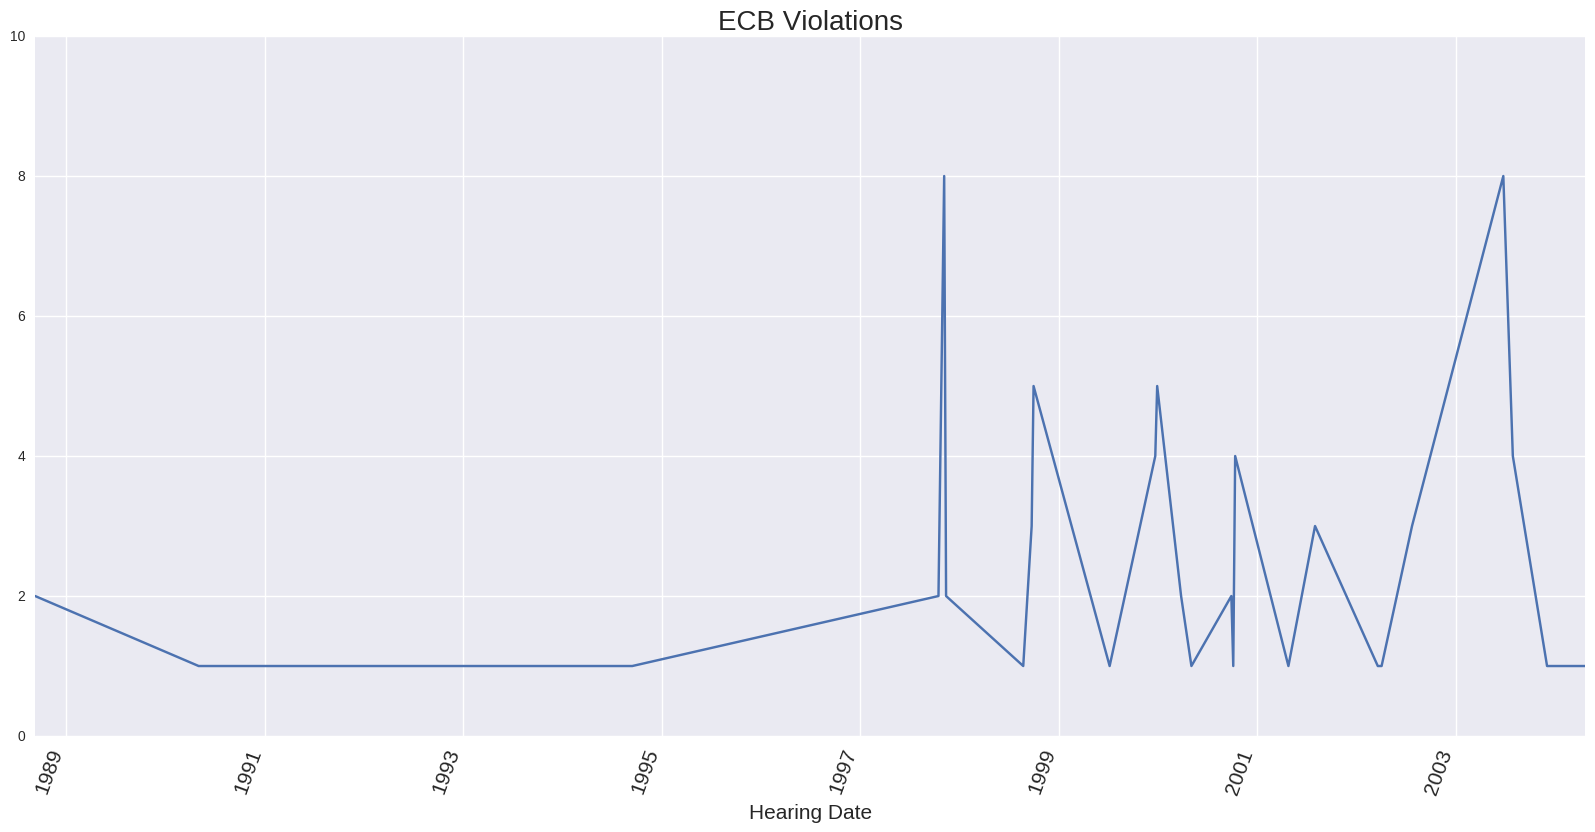

In [87]:
fig = plt.figure()
data.plot(figsize=(20,10))
plt.xticks(rotation=70, fontsize=15)
plt.ylim(0,10)
plt.title('ECB Violations', fontsize=20)
plt.xlabel('Hearing Date', fontsize=15)
plt.show()

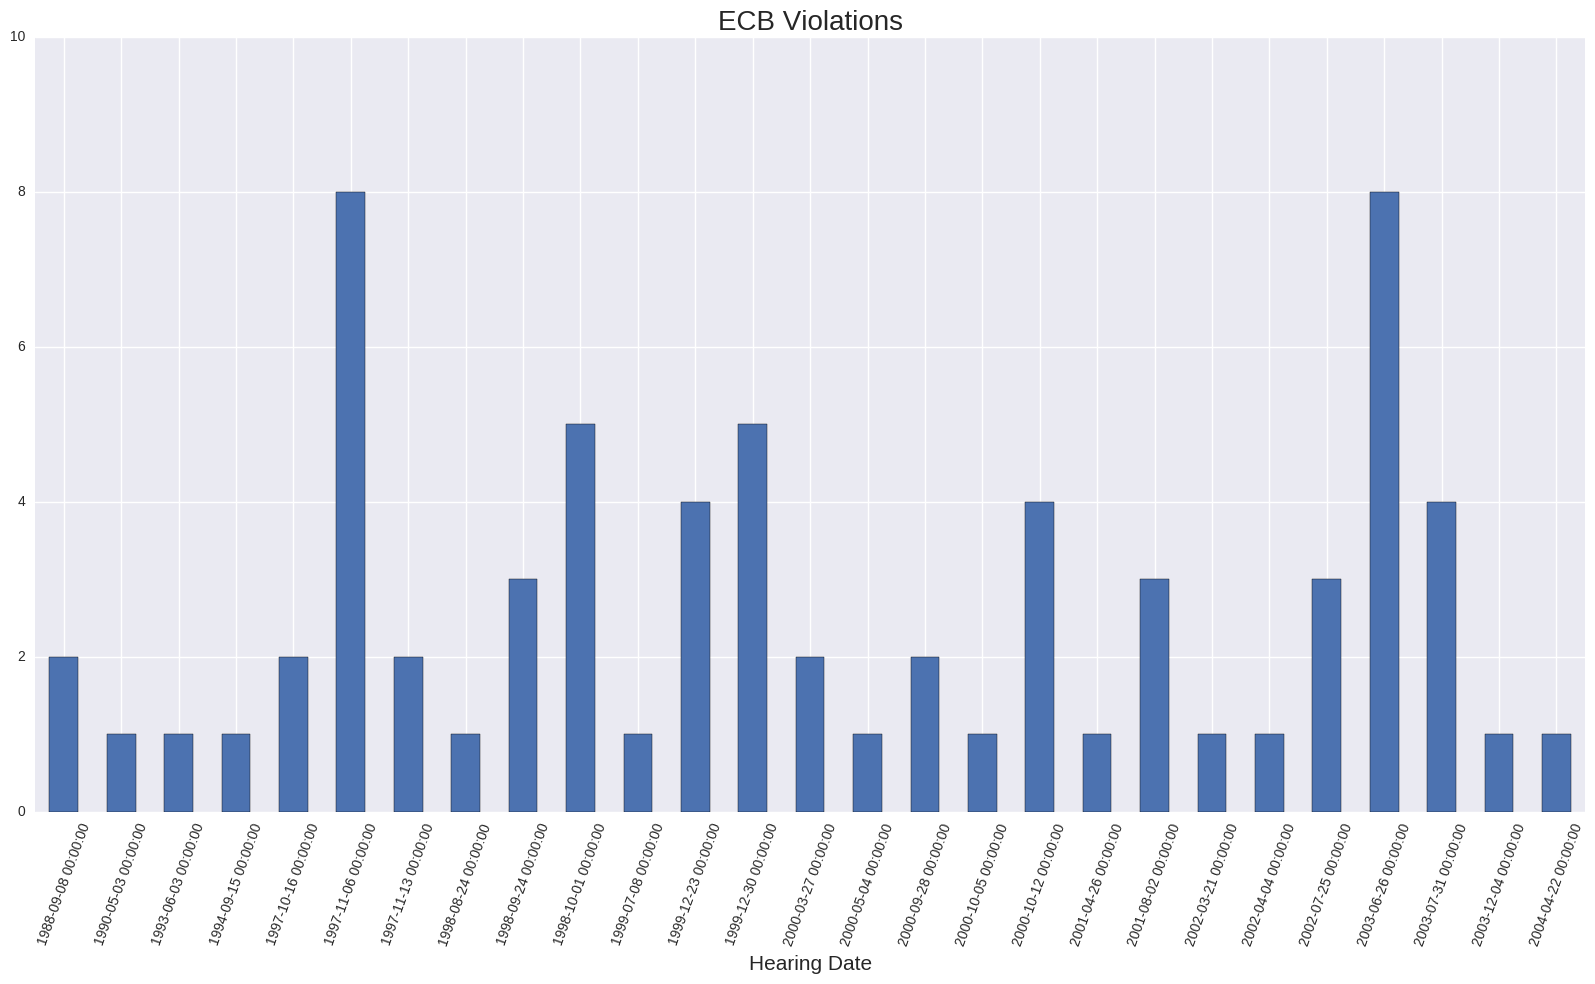

In [98]:
fig = plt.figure()
data.plot(kind='bar',figsize=(20,10))
plt.xticks(rotation=70, fontsize=10)
plt.ylim(0,10)
plt.xlabel('Hearing Date', fontsize=15)
plt.title('ECB Violations',fontsize=20)
plt.show()

In [37]:
example_query ='''
Select *, properties.borough || '-' || properties.block || '-' || properties.lot as bblconcat
from agn_buildings.acris_parties as parties
left join agn_buildings.acris_pp_legal as properties
on parties.DOCUMENT_ID = properties.document_id
left join agn_buildings.pluto as p
on properties.borough || '-' || properties.block || '-' || properties.lot = p.bbldash
left join agn_buildings.hpd_violations as hdpviolations
on properties.borough || '-' || properties.block || '-' || properties.lot =
hdpviolations.boroid  || '-' || hdpviolations.block || '-' || hdpviolations.lot
where parties.name ilike '%ciampa%';
'''
#where parties.address_1 ilike '136-26 37TH AVENUE'

conn = db_connection()
try:
    dfBuildingsForLandlord = pd.read_sql(example_query, conn)
finally:
    conn.close()
dfBuildingsForLandlord.head()


#dfBuildingsForLandlord_group = dfBuildingsForLandlord.groupby('bblconcat')

#dfBuildingsForLandlord_group.size()

,document_id,record_type,party_type,name,address_1,address_2,country,city,state,zip,...,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,bblconcat
0,2004072301560001,P,1,CIAMPA 162 LLC,136-26 37TH AVENUE,None,US,FLUSHING,NY,11354,...,None,None,566,3459379.0,Â§ 27-2018 ADM CODE ABATE THE NUISANCE CONSIST...,09/09/2008,19.0,VIOLATION CLOSED,12/30/2015,4-9760-22
1,2004072301560001,P,1,CIAMPA 162 LLC,136-26 37TH AVENUE,None,US,FLUSHING,NY,11354,...,None,02/25/2014,501,4725798.0,Â§ 27-2005 ADM CODE PROPERLY REPAIR THE BROKEN...,11/15/2013,2.0,NOV SENT OUT,10/14/2015,4-9760-22
2,2004072301560001,P,1,CIAMPA 162 LLC,136-26 37TH AVENUE,None,US,FLUSHING,NY,11354,...,None,12/02/2013,526,4725799.0,"Â§ 27-2005, 2007 ADM CODE REMOVE THE ILLEGAL F...",11/15/2013,19.0,VIOLATION CLOSED,12/30/2015,4-9760-22
3,2004072301560001,P,1,CIAMPA 162 LLC,136-26 37TH AVENUE,None,US,FLUSHING,NY,11354,...,None,02/25/2014,501,4725798.0,Â§ 27-2005 ADM CODE PROPERLY REPAIR THE BROKEN...,11/15/2013,2.0,NOV SENT OUT,10/14/2015,4-9760-22
4,2004072301560001,P,1,CIAMPA 162 LLC,136-26 37TH AVENUE,None,US,FLUSHING,NY,11354,...,None,None,566,2972235.0,Â§ 27-2018 ADM CODE ABATE THE NUISANCE CONSIST...,05/14/2007,19.0,VIOLATION CLOSED,12/30/2015,4-9760-22


In [41]:
example_query ='''
Select *, properties.borough || '-' || properties.block || '-' || properties.lot as bblconcat
from agn_buildings.acris_parties as parties
left join agn_buildings.acris_pp_legal as properties
on parties.DOCUMENT_ID = properties.document_id
left join agn_buildings.pluto as p
on properties.borough || '-' || properties.block || '-' || properties.lot = p.bbldash
left join agn_buildings.dob_violations as dobviolations
on properties.borough || '-' || properties.block || '-' || properties.lot =
dobviolations.boro || '-' || dobviolations.block || '-' || dobviolations.lot
where parties.name ilike '%ciampa%';
'''
#where parties.address_1 ilike '136-26 37TH AVENUE'

conn = db_connection()
try:
    dfBuildingsForLandlord = pd.read_sql(example_query, conn)
finally:
    conn.close()
dfBuildingsForLandlord.head()

# dfBuildingsForLandlord_group = dfBuildingsForLandlord.groupby('bblconcat')

# dfBuildingsForLandlord_group.size()

,document_id,record_type,party_type,name,address_1,address_2,country,city,state,zip,...,disposition_date,disposition_comments,device_number,description,ecb_number,number,violation_category,violation_type,issue_date_date,bblconcat
0,2013091600652001,P,1,"CIAMPA, MARY GRANT",122 STONY BROOK ROAD,None,US,BELMONT,MA,02478,...,None,None,None,None,None,None,None,None,None,1-1203-37
1,2013091600652001,P,1,"CIAMPA, JULIA GRANT",122 STONY BROOK ROAD,None,US,BELMONT,MA,02478,...,None,None,None,None,None,None,None,None,None,1-1203-37
2,FT_1530000491953,P,2,"CIAMPA, JOHN",1894 STRONG ROAD,None,US,VICTOR,NY,14564,...,None,None,None,None,None,None,None,None,None,1-1867-59
3,2003042801505001,P,1,"CIAMPA, WILLIAM A",360 WEST 22ND STREET,None,US,NEW YORK,NY,10011,...,None,None,None,None,None,None,None,None,None,1-745-1102
4,FT_1380006354938,P,1,"CIAMPA, WILLIAM A.",360 WEST 22ND STREET,None,US,NEW YORK,NY,10011,...,None,None,None,None,None,None,None,None,None,1-745-1102


In [19]:
dfBuildingsForLandlord.hearing_date.dtype

dtype('O')

In [20]:
dfBuildingsForLandlord['hearing_date'] = pd.to_datetime(dfBuildingsForLandlord.hearing_date, format='%Y%m%d')

In [21]:
data = dfBuildingsForLandlord.ecb_violation_number.groupby(by=dfBuildingsForLandlord.hearing_date).count()

In [22]:
dfBuildingsForLandlord.hearing_date.dtype

dtype('<M8[ns]')

In [100]:
example_query ='''
Select * 
from agn_buildings.acris_parties as parties
left join agn_buildings.acris_legal as properties
on parties.DOCUMENT_ID = properties.document_id
left join agn_buildings.dob_ecbviolations as ecbviolations
on properties.bbl =
ecbviolations.boro || '-' || ecbviolations.block || '-' || ecbviolations.lot 
where parties.name ilike '%ciampa%';
'''

conn = db_connection()
try:
    df_join = pd.read_sql(example_query, conn)
finally:
    conn.close()
df_join.head()

,document_id,record_type,party_type,name,address_1,address_2,country,city,state,zip,...,infraction_code8,section_law_description8,infraction_code9,section_law_description9,infraction_code10,section_law_description10,aggravated_level,hearing_status,certification_status,hearing_date_date
0,2003022801184001,P,1,"CIAMPA BRADDOCK, INC.",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,FT_3010001416501,P,1,"CIAMPA, JOHN",None,None,US,None,None,00000,...,None,None,None,None,None,None,None,None,None,None
2,FT_3010001416501,P,1,"CIAMPA, ANGELINA",None,None,US,None,None,00000,...,None,None,None,None,None,None,None,None,None,None
3,FT_3420001179142,P,1,"CIAMPA, ANGELINA",368 FORBELL ST,None,US,BKLYN,NY,00000,...,None,None,None,None,None,None,None,None,None,None
4,FT_3420001179142,P,1,"CIAMPA, JOHN",368 FORBELL ST,None,US,BKLYN,NY,00000,...,None,None,None,None,None,None,None,None,None,None


In [86]:
## Query to get the table description and the comments 

example_query ='''
SELECT n.nspname AS schema_name, 
pg_get_userbyid(c.relowner) AS table_owner, 
c.relname AS table_name, 
CASE WHEN c.relkind = 'v' THEN 'view' ELSE 'table' END AS table_type, 
d.description AS table_description
FROM pg_class As c
LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
LEFT JOIN pg_tablespace t ON t.oid = c.reltablespace
LEFT JOIN pg_description As d
ON (d.objoid = c.oid AND d.objsubid = 0)
WHERE c.relkind IN('r', 'v') AND d.description > ''
ORDER BY n.nspname, c.relname;
'''
conn = db_connection()
try:
    df1 = pd.read_sql(example_query, conn)
finally:
    conn.close()
df1.head()

,schema_name,table_owner,table_name,table_type,table_description
0,agn_buildings,jwerberg,acris_codes,table,ACRIS codes for document type and party type. ...
1,agn_buildings,rholbrook,acris_legal,table,ACRIS legal table links documents to particula...
2,agn_buildings,rholbrook,acris_master,table,"ACRIS master table - one record per document, ..."
3,agn_buildings,rholbrook,acris_parties,table,ACRIS parties table links all parties to docum...
4,agn_buildings,jwerberg,acris_pp_legal,table,"ACRIS personal property legal table, merged in..."
